In [1]:
import os
os.chdir("../../")

In [2]:
from pathlib import Path
data = Path("data/")

In [ ]:
# We will only use them for plotting below
import scanpy as sc
import muon as mu

Throughout the notebook we will also track how much memory the notebook consumes after loading different objects into memory.

This won't provide exact measurement but will allow to see the order of magnitude of memory consumption:

In [4]:
import os, psutil
def measure_memory() -> float:
    return psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2

## Shadow objects

A lot of exploratory and downstream analyses and visualisations require read-only access to the data.

While AnnData (and MuData) [provides](https://anndata.readthedocs.io/en/latest/generated/anndata.read_h5ad.html) support to delay reading the count matrix `.X` into memory, it currently does not provide a lightweight read-only access to the file contents.

This is addressed by the new classes implemented in `shadows` — *AnnDataShadow* and *MuDataShadow*.
Briefly, they mimic AnnData and MuData interfaces while keeping a connection to the file open and loading respective arrays, matrices and tables only when they are requested.

Shadow objects are currently only implemented for H5AD and H5MU files.

Import classes for these shadow objects:

In [5]:
from shadows import AnnDataShadow, MuDataShadow

First, let's download a multimodal dataset in the H5MU format:

In [6]:
import mudatasets

# Memory consumption before (in MiB)
mem_before = measure_memory()

mdata = mudatasets.load("pbmc5k_citeseq", files=["pbmc5k_citeseq_processed.h5mu"], data_dir=data, backed=False)
# This will return a MuData objects after downloading the file,
# but we will discard the in-memory object

# Memory consumption after (in MiB)
mem_after = measure_memory()

print(f"Loading MuData took about {(mem_after - mem_before):.2f} MiB of memory")

import gc
del mdata
gc.collect();

■ File pbmc5k_citeseq_processed.h5mu from pbmc5k_citeseq has been found at data/pbmc5k_citeseq/pbmc5k_citeseq_processed.h5mu
■ Checksum is validated (md5) for pbmc5k_citeseq_processed.h5mu
■ Loading pbmc5k_citeseq_processed.h5mu...
Loading MuData took about 394.68 MiB of memory


### Access and memory consumption

In [7]:
mem_start = measure_memory()

Now we can initialise a new MuData-like (in reality, a MuDataShadow) object:

In [8]:
file = data / "pbmc5k_citeseq/pbmc5k_citeseq_processed.h5mu"

# Memory consumption before (in MiB)
mem_before = measure_memory()

mdata = MuDataShadow(file)
#       ^ This will traverse the file 
#         but will not load any matrices or data frames

# Memory consumption after (in MiB)
mem_after = measure_memory()

print(f"MuDataShadow took about {(mem_after - mem_before)} MiB of memory")

MuDataShadow took about 0.0 MiB of memory


In [9]:
mdata = MuDataShadow(file)
print(mdata['rna'].raw)
mdata['rna'].raw.X[:,10]
print(mdata['rna'].raw)

raw:	X, var, varm

raw:	Xᐁ, var, varm



In [10]:
mdata

MuData Shadow object with n_obs × n_vars = 3891 × 17838
  obs:	_index, leiden, leiden_wnn, louvain
  var:	_index, feature_types, gene_ids, highly_variable
  obsm:	X_mofa, X_mofa_umap, X_umap, X_wnn_umap, prot, rna
  varm:	LFs, prot, rna
  obsp:	connectivities, distances, wnn_connectivities, wnn_distances
  uns:	leiden, leiden_wnn_colors, louvain, neighbors, rna:celltype_colors, umap, wnn
  obsmap:	prot, rna
  varmap:	prot, rna
  mod:	2 modalities
    prot: 3891 x 32
        X  
        layers:	counts
        obs:	_index
        var:	_index, feature_types, gene_ids, highly_variable
        obsm:	X_pca, X_umap
        varm:	PCs
        obsp:	connectivities, distances
        uns:	neighbors, pca, umap
    rna: 3891 x 17806
        X  
        raw:	Xᐁ, var, varm
        obs:	_index, celltype, leiden, n_genes_by_counts, pct_counts_mt, total_counts, total_counts_mt
        var:	_index, dispersions, dispersions_norm, feature_types, gene_ids, highly_variable, mean, mean_counts, means, mt, n_ce

Individual modalities are `AnnDataShadow` objects:

In [11]:
mdata['rna']

AnnData Shadow object with n_obs × n_vars = 3891 × 17806
  X  
  raw:	Xᐁ, var, varm
  obs:	_index, celltype, leiden, n_genes_by_counts, pct_counts_mt, total_counts, total_counts_mt
  var:	_index, dispersions, dispersions_norm, feature_types, gene_ids, highly_variable, mean, mean_counts, means, mt, n_cells_by_counts, pct_dropout_by_counts, std, total_counts
  obsm:	X_pca, X_umap
  varm:	PCs
  obsp:	connectivities, distances
  uns:	celltype_colors, hvg, leiden, leiden_colors, neighbors, pca, rank_genes_groups, umap

### Caching

In [12]:
# Memory consumption before reading some of the attributes
mem_before = measure_memory()

We can use the values of the shadow object just as values in a regular MuData. They will be loaded from the object and cached:

In [13]:
rna_obs = mdata.mod["rna"].obs
rna_obs

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,celltype
AAACCCAAGAGACAAG-1,2363,7375.0,467.0,6.332204,3,intermediate mono
AAACCCAAGGCCTAGA-1,1259,3772.0,343.0,9.093319,0,CD4+ naïve T
AAACCCAGTCGTGCCA-1,1578,4902.0,646.0,13.178295,2,CD4+ memory T
AAACCCATCGTGCATA-1,1908,6704.0,426.0,6.354415,2,CD4+ memory T
AAACGAAAGACAAGCC-1,1589,3900.0,363.0,9.307693,1,CD14 mono
...,...,...,...,...,...,...
TTTGGTTGTACGAGTG-1,1450,5666.0,367.0,6.477232,0,CD4+ naïve T
TTTGTTGAGTTAACAG-1,3068,10213.0,896.0,8.773132,9,intermediate mono
TTTGTTGCAGCACAAG-1,1649,4754.0,468.0,9.844342,4,CD8+ memory T
TTTGTTGCAGTCTTCC-1,1901,6373.0,553.0,8.677233,2,CD4+ memory T


Individual matrices or data frames from `.obsm`, `.obsp`, `.layers`, etc. can be loaded allowing to only load e.g. a particular embedding of the data:

In [14]:
rna_pca = mdata["rna"].obsm["X_pca"]
rna_pca

array([[ 20.551052  ,   0.36840764,  -1.6193684 , ...,   0.09656975,
         -0.90912175,  -0.77955467],
       [ -9.47144   ,  -5.5212517 ,  -5.107428  , ...,   0.64674896,
         -0.892091  ,   1.7873902 ],
       [ -9.913012  ,   2.766899  ,  -2.0684972 , ...,  -0.6454743 ,
          1.615869  ,  -0.63476324],
       ...,
       [ -8.727723  ,   7.9196725 ,   1.3326805 , ...,   1.4592032 ,
          0.91210324,   1.3184382 ],
       [-10.792531  ,   3.2086673 ,  -2.0437238 , ...,   1.7311838 ,
         -1.840564  ,   1.3253008 ],
       [ 20.642431  ,   0.49294943,  -1.6694897 , ...,  -0.51208967,
          0.60652566,  -0.75145006]], dtype=float32)

Notice the symbol `ᐁ` near the respective table (`/mod/rna/obs`) and matrix (`/mod/rna/obsm/X_pca`) indicating that the value has already been loaded into memory:

In [15]:
mdata

MuData Shadow object with n_obs × n_vars = 3891 × 17838
  obs:	_index, leiden, leiden_wnn, louvain
  var:	_index, feature_types, gene_ids, highly_variable
  obsm:	X_mofa, X_mofa_umap, X_umap, X_wnn_umap, prot, rna
  varm:	LFs, prot, rna
  obsp:	connectivities, distances, wnn_connectivities, wnn_distances
  uns:	leiden, leiden_wnn_colors, louvain, neighbors, rna:celltype_colors, umap, wnn
  obsmap:	prot, rna
  varmap:	prot, rna
  mod:	2 modalities
    prot: 3891 x 32
        X  
        layers:	counts
        obs:	_index
        var:	_index, feature_types, gene_ids, highly_variable
        obsm:	X_pca, X_umap
        varm:	PCs
        obsp:	connectivities, distances
        uns:	neighbors, pca, umap
    rna: 3891 x 17806
        X  
        raw:	Xᐁ, var, varm
        obs:	_index, celltype, leiden, n_genes_by_counts, pct_counts_mt, total_counts, total_counts_mt
        var:	_index, dispersions, dispersions_norm, feature_types, gene_ids, highly_variable, mean, mean_counts, means, mt, n_ce

Let's load count matrices for a noticeable effect on memory consumption:

In [16]:
rna_x = mdata["rna"].X
prot_x = mdata["prot"].X

In [17]:
# Memory consumption after loading .obs, .obsm["X_pca"] for RNA,
# and count matrices for RNA and proteins
mem_after = measure_memory()

In [18]:
print(f"Reading these few objects took about {(mem_after - mem_before):.2f} MiB of memory")

Reading these few objects took about 266.30 MiB of memory


Cache can be cleared:

In [19]:
mdata.clear_cache()
mdata

MuData Shadow object with n_obs × n_vars = 3891 × 17838
  obs:	_index, leiden, leiden_wnn, louvain
  var:	_index, feature_types, gene_ids, highly_variable
  obsm:	X_mofa, X_mofa_umap, X_umap, X_wnn_umap, prot, rna
  varm:	LFs, prot, rna
  obsp:	connectivities, distances, wnn_connectivities, wnn_distances
  uns:	leiden, leiden_wnn_colors, louvain, neighbors, rna:celltype_colors, umap, wnn
  obsmap:	prot, rna
  varmap:	prot, rna
  mod:	2 modalities
    prot: 3891 x 32
        X  
        layers:	counts
        obs:	_index
        var:	_index, feature_types, gene_ids, highly_variable
        obsm:	X_pca, X_umap
        varm:	PCs
        obsp:	connectivities, distances
        uns:	neighbors, pca, umap
    rna: 3891 x 17806
        X  
        raw:	X, var, varm
        obs:	_index, celltype, leiden, n_genes_by_counts, pct_counts_mt, total_counts, total_counts_mt
        var:	_index, dispersions, dispersions_norm, feature_types, gene_ids, highly_variable, mean, mean_counts, means, mt, n_cel

(No more `obsᐁ` and `X_pcaᐁ`!)

In [20]:
del rna_obs, rna_pca, rna_x, prot_x
gc.collect()

16

In [21]:
print(f"After clearing cache, memory consumption change is {(measure_memory() - mem_after)} MiB")

After clearing cache, memory consumption change is -264.33984375 MiB


### External tools

As AnnDataShadow and MuDataShadow mimic AnnData and MuData interfaces, most of the read-only functionality of [the whole ecosystem of scverse tools](https://scverse.org/packages/), including [scanpy](https://scanpy.rtfd.io/) and [muon](https://muon.scverse.org/), is supported out of the box:

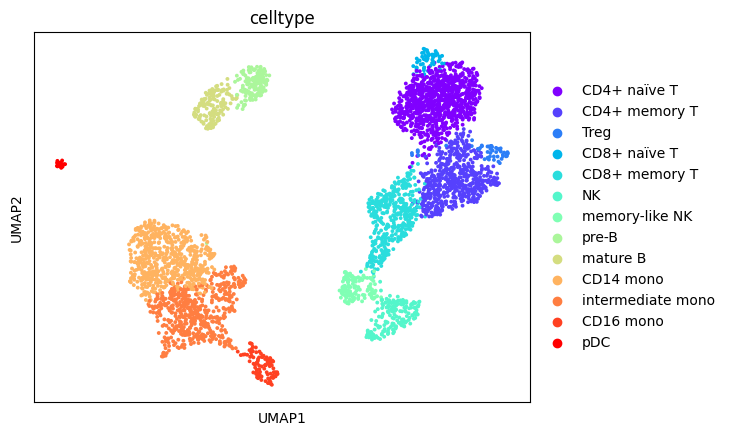

In [22]:
sc.pl.umap(mdata["rna"], color="celltype")

Notice that the colours were fetched from the respective array in `.uns`:

In [23]:
mdata['rna'].uns['celltype_colors']

array(['#8000ff', '#5641fd', '#2c7ef7', '#00b5eb', '#2adddd', '#54f6cb',
       '#80ffb4', '#abf69b', '#d4dd80', '#ffb360', '#ff7e41', '#ff4121',
       '#ff0000'], dtype=object)

Moreoever, they were only loaded from file when requested. We can see that an array with these value is cached now:

In [24]:
mdata['rna'].uns

uns:	celltype_colorsᐁ, hvg, leiden, leiden_colors, neighbors, pca, rank_genes_groups, umap

The same works for muon:

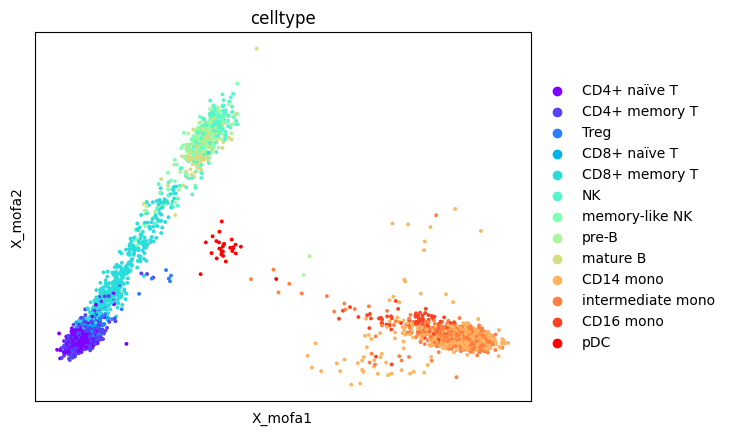

In [25]:
mdata.obs['celltype'] = mdata['rna'].obs.celltype
mdata.uns['celltype_colors'] = mdata['rna'].uns['celltype_colors']

mu.pl.mofa(mdata, color="celltype")

### Adding data to the in-memory object

Shadow objects also allow to have new data added to them, for instance new embeddings:

> [!NOTE]
> Data added to in-memory shadow objects can be saved on disk as demonstrated [in another tutorial](shadows-features.ipynb).

In [26]:
# For simplicity, we will copy an embedding
mdata.obsm["X_mofa_copy"] = mdata.obsm["X_mofa"].copy()

Notice a new symbol (`▲`) to signify an in-memory object:

In [27]:
mdata

MuData Shadow object with n_obs × n_vars = 3891 × 17838
  obs:	_index, leiden, leiden_wnn, louvain
  var:	_index, feature_types, gene_ids, highly_variable
  obsm:	X_mofaᐁ, X_mofa_umapᐁ, X_umapᐁ, X_wnn_umapᐁ, protᐁ, rnaᐁ, X_mofa_copy▲
  varm:	LFs, prot, rna
  obsp:	connectivitiesᐁ, distancesᐁ, wnn_connectivitiesᐁ, wnn_distancesᐁ
  uns:	leiden, leiden_wnn_colors, louvain, neighbors, rna:celltype_colors, umap, wnn, celltype_colors▲
  obsmap:	prot, rna
  varmap:	prot, rna
  mod:	2 modalities
    prot: 3891 x 32
        X  
        layers:	counts
        obs:	_index
        var:	_index, feature_types, gene_ids, highly_variable
        obsm:	X_pca, X_umap
        varm:	PCs
        obsp:	connectivities, distances
        uns:	neighbors, pca, umap
    rna: 3891 x 17806
        X  
        raw:	X, var, varm
        obs:	_index, celltype, leiden, n_genes_by_counts, pct_counts_mt, total_counts, total_counts_mt
        var:	_index, dispersions, dispersions_norm, feature_types, gene_ids, highly_var

> [!NOTE] 
> Adding columns to data frames or altering objects otherwise is currently not being registered by shadow objects.

### Wind down

In [28]:
mdata.clear_cache()
mdata.close()

`mdata` cannot be used after the connection is closed:

In [29]:
try:
    print(mdata)
except ValueError as e:
    print("MuData is not available:", e)

MuData is not available: Invalid location identifier (invalid location identifier)


In [30]:
del mdata
gc.collect()

9378

In [31]:
print(f"In the end, memory consumption is {(measure_memory() - mem_start)} MiB up")

In the end, memory consumption is -1.2421875 MiB up
